In [2]:
def distribution_prices():
    pass

In [3]:
def special_day_analysis(ebd):
    import pandas as pd
    import sys, os
    sys.path.append(os.path.join(os.path.dirname(''), '../..'))
    from proj2_eniac_price_discounts.src.DSBC_proj2_utils import unpack_dict, pack_dict
    products, orders, orderlines, brands = unpack_dict(ebd)
    
    #
    all_orders = orderlines.merge(orders, right_on='order_id', left_on='id_order')
    all_orders =  all_orders.assign(
            created_day = pd.to_datetime(all_orders['created_date']).dt.strftime('%-j'),
            day = pd.to_datetime(all_orders['date']).dt.strftime('%j'),
            year = pd.to_datetime(all_orders['date']).dt.strftime('%Y')
    ).query('year != "2018"')
    
    all_orders = get_discounts(all_orders, products)
    disc_col = 'discount_perc'
    
    #counts the number of occurences of all states
    from collections import Counter
    def count_state_to_dict(x):
        state_dict = {
            'Cancelled': 0, 
            'Completed': 0, 
            'Pending': 0, 
            'Shopping Basket': 0, 
            'Place Order': 0
        }
    
        state_dict.update(Counter(x.tolist()))
        return pd.DataFrame(state_dict, index=[int(x.name) - 1])

    #multiple index resets necessary in order to put all columns together
    grpday = all_orders.groupby('day')
    all_orders_grpday_statecount = (
        grpday['state']
        .apply(count_state_to_dict)
        .reset_index()
        .drop('level_1', axis=1)
    )
    all_orders_grpday_statecount.loc[:,disc_col + '_sum'] = grpday[disc_col].sum().reset_index()[disc_col]
    all_orders_grpday_statecount.loc[:,disc_col + '_avg'] = grpday[disc_col].mean().reset_index()[disc_col]
    return all_orders_grpday_statecount

In [4]:
def corr_heatmap(df):
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot  as plt
    
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5) 

In [5]:
def get_discounts(all_orders, products):    
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    ol_prices = (
    all_orders                             #<------ changed
        .groupby(by=['sku',"day",'state']) #<------ changed
        .agg(
            min_ol_price=("unit_price", "min"),
            mean_ol_price=("unit_price", "mean"),
            max_ol_price=("unit_price", "max"))
        .reset_index()
    )
    ol_prices.head()
    ol_prices.mean_ol_price.isnull().sum()

    products01 = pd.merge(products, ol_prices, left_on="sku", right_on="sku", how='inner')
    
    products01["price_diff"] = products01["price"] - products01["mean_ol_price"]
    products01["discount_perc"] = 100-products01["mean_ol_price"]/products01["price"]*100
    
    return products01

In [6]:
def plot_discount_over_days(disc_kind):
    import seaborn as sns
    g = sns.relplot(
        data=all_orders_grpday_statecount, 
        kind='line',
        x='day', 
        y='discount_perc_' + disc_kind,
        linewidth = 2.5,
        aspect=2
    )
    return g

In [54]:
def find_conspicious_days(all_orders_grpday_statecount, disc_kind):
    disc = 'discount_perc_' + disc_kind
    large_disc_min = all_orders_grpday_statecount[disc].nlargest(10).min()
    small_disc_max = all_orders_grpday_statecount[disc].nsmallest(10).max()

    mask = (all_orders_grpday_statecount[disc] >= large_disc_min) \
            | (all_orders_grpday_statecount[disc] <= small_disc_max)

    conspicious_days = all_orders_grpday_statecount[mask]
    conspicious_days.loc[:,'weekday'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.weekday
    conspicious_days.loc[:,'dayofmonth'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.day
    conspicious_days.loc[:,'month'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.month

    return conspicious_days

In [56]:
if True:
    import nbimporter
    import pandas as pd
    import sys, os
    sys.path.append(os.path.join(os.path.dirname(''), '../..'))
    from proj2_eniac_price_discounts.DSBC_proj2_main import load_clean_data

    ebd = load_clean_data(path = '../data/')
    all_orders_grpday_statecount = special_day_analysis(ebd)
    
    #drop rows with neg discount
    no_of_neg_rows = (all_orders_grpday_statecount['discount_perc_sum'] < 0).sum()
    idx_of_neg_rows = all_orders_grpday_statecount['discount_perc_sum'].nsmallest(no_of_neg_rows).index
    all_orders_grpday_statecount.drop(idx_of_neg_rows, inplace=True)
    
    conspicious_days = find_conspicious_days(all_orders_grpday_statecount, 'avg')
    conspicious_days.sort_values(by='discount_perc_avg')

C:\Users\circl\AppData\Local\Temp\ipykernel_9384\1145905422.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspicious_days.loc[:,'weekday'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.weekday
C:\Users\circl\AppData\Local\Temp\ipykernel_9384\1145905422.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conspicious_days.loc[:,'dayofmonth'] = pd.to_datetime(conspicious_days['day'], format='%j').dt.day
C:\Users\circl\AppData\Local\Temp\ipykernel_9384\1145905422.py:12: SettingWithCopyWarni

In [57]:
conspicious_days

,day,Cancelled,Completed,Pending,Shopping Basket,Place Order,discount_perc_sum,discount_perc_avg,weekday,dayofmonth,month
26,027,16,170,29,216,68,11480.750523,24.119224,5,27,1
27,028,7,115,10,177,46,7583.598982,22.637609,6,28,1
28,029,6,138,20,196,72,9190.636054,22.039895,0,29,1
96,097,9,19,55,162,66,3222.783288,10.531972,5,7,4
111,112,7,66,7,122,32,2481.789987,10.790391,6,22,4
123,124,10,91,38,187,45,4362.704406,11.952615,4,4,5
169,170,13,57,97,204,65,5034.395579,11.790154,1,19,6
180,181,21,104,58,276,85,11564.549998,21.656461,5,30,6
184,185,17,132,31,194,72,3085.304943,7.125416,2,4,7
189,190,7,114,19,187,42,8127.696668,22.390349,0,9,7


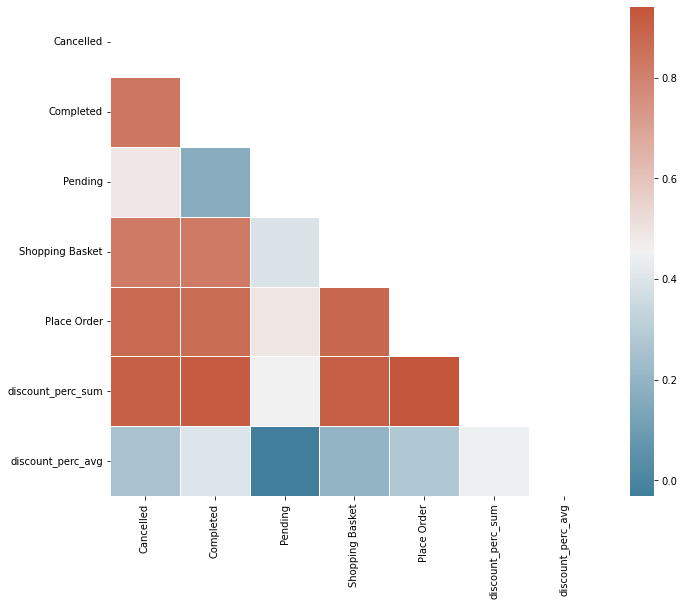

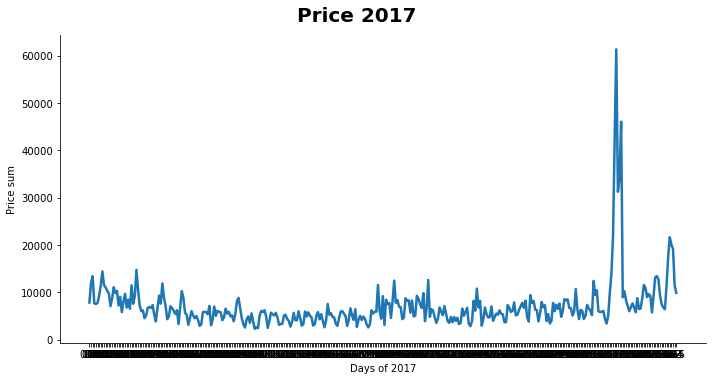

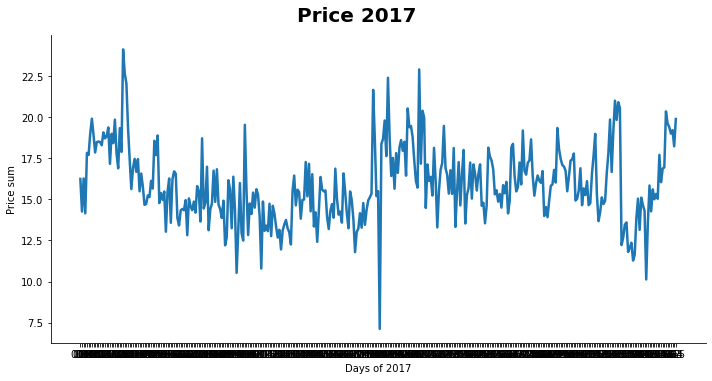

In [43]:
if True:
    #plots
    corr_heatmap(all_orders_grpday_statecount)
    
    g = plot_discount_over_days('sum')
    g.fig.suptitle('Price 2017', y=1.05, fontsize=20, fontweight='bold')
    g.set_axis_labels("Days of 2017", "Price sum") 
    
    g = plot_discount_over_days('avg')
    g.fig.suptitle('Price 2017', y=1.05, fontsize=20, fontweight='bold')
    g.set_axis_labels("Days of 2017", "Price sum") 

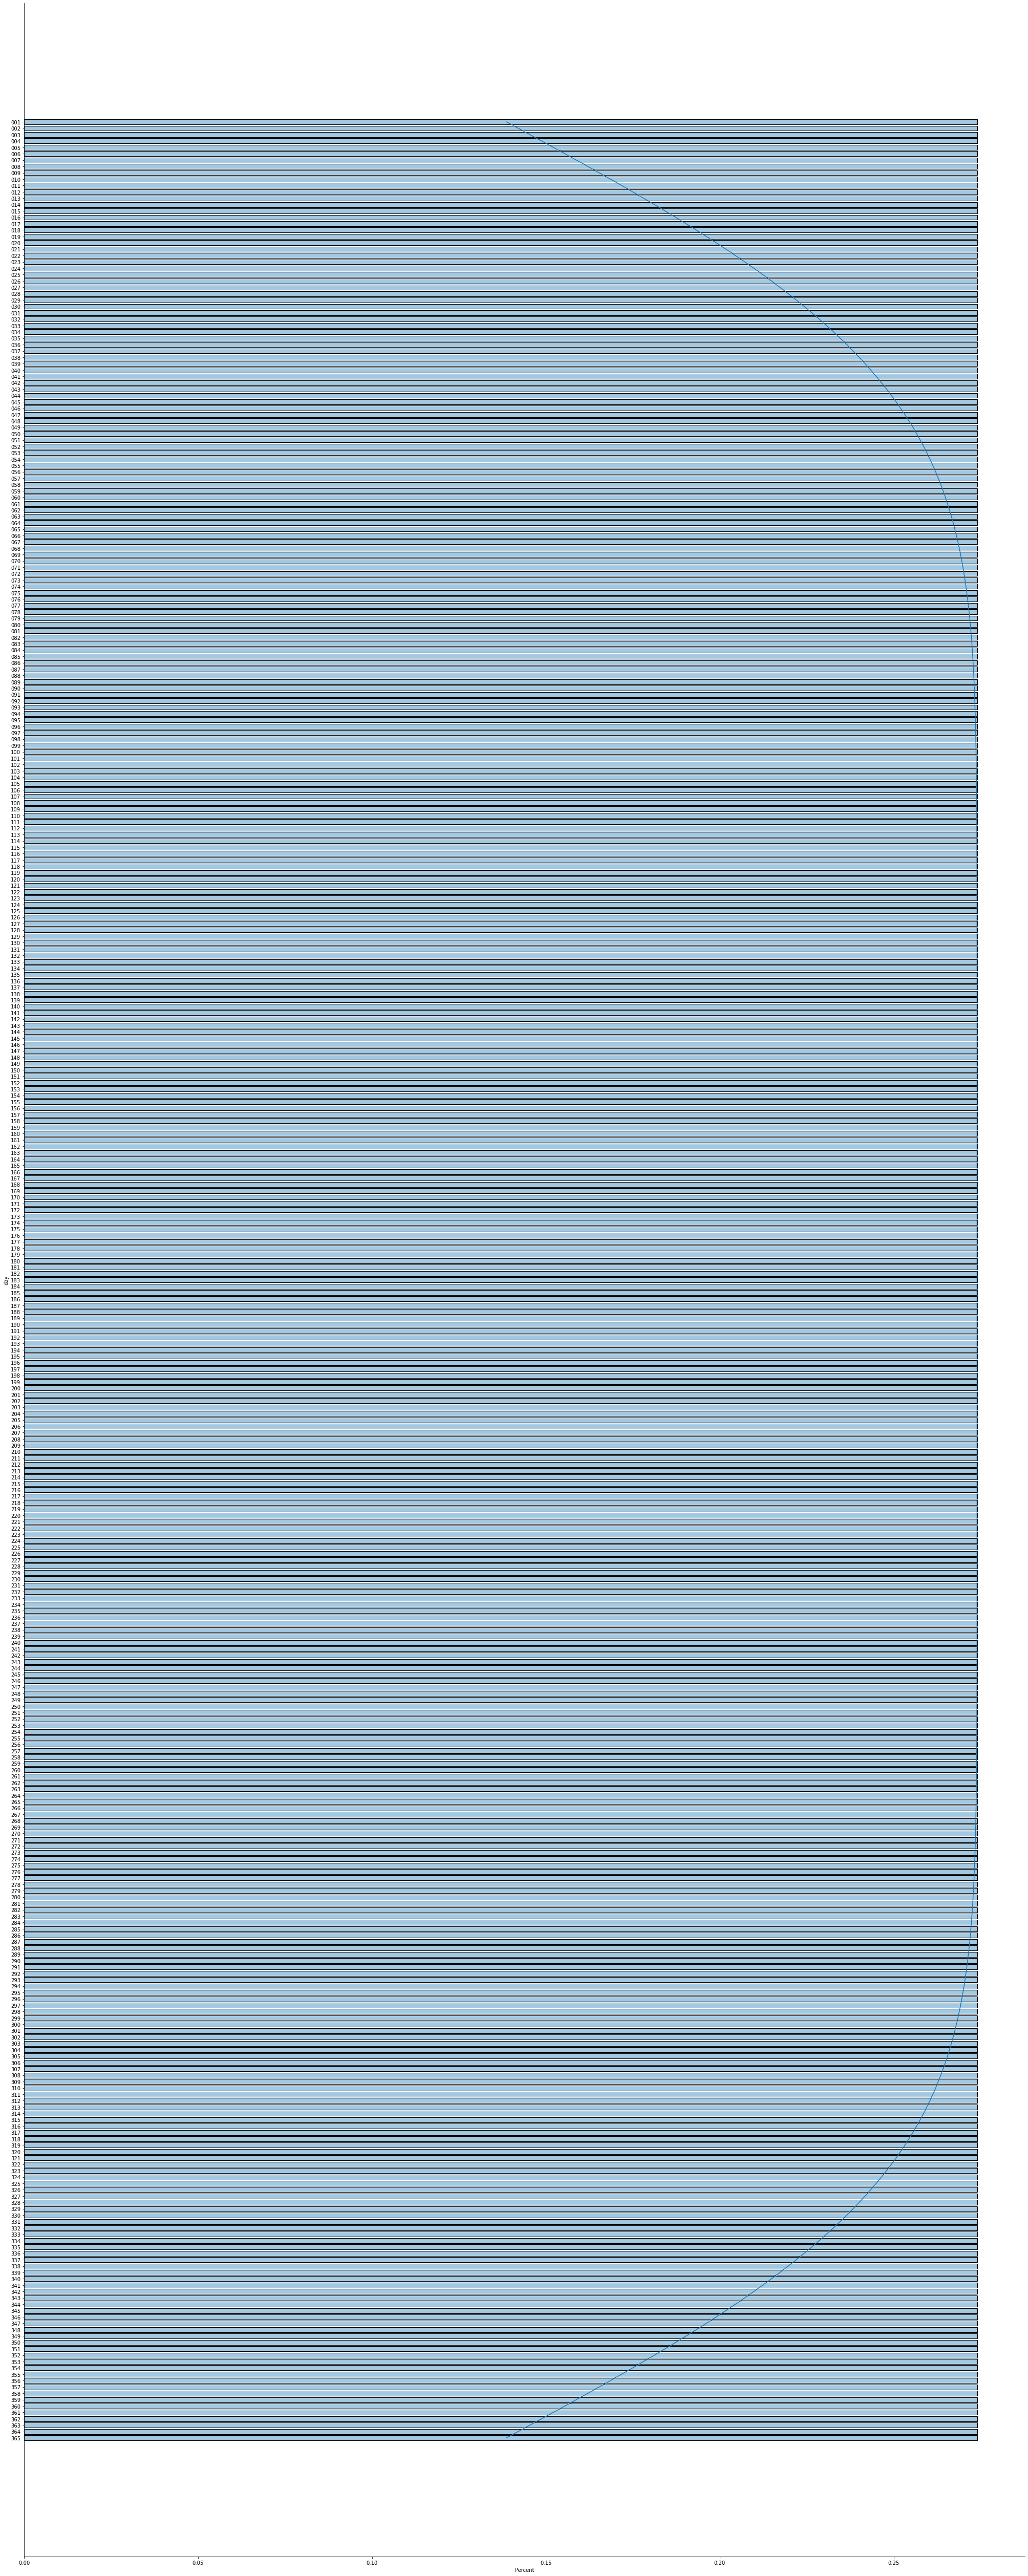

In [24]:
import seaborn as sns
g = sns.displot(
    data=all_orders_grpday_statecount,
    kind='hist',
    #x='completed',
    y='day', 
    alpha=.4, # add transparency to you chart
    #multiple="stack",
    element='bars',
    stat='percent',
    shrink=.8,
    kde=True, # add a density line in the histogram
    height=70,
    aspect=.4
)